In [1]:
%matplotlib inline
from __future__ import division
import numpy as np
np.random.seed(123456789)   # repeatable results
import matplotlib.pyplot as pl
import matplotlib.mlab as mlab
import scipy.signal as sig
import scipy.constants as const
from scipy import interpolate
import corner
import emcee as mc
import pickle

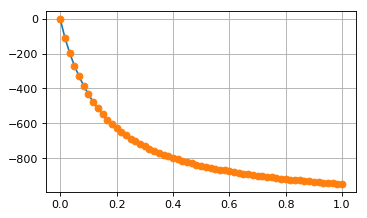

In [2]:
### Load comsol model for thermal lens
# Comsol model of the self heating
model = np.loadtxt('1W_self_heating_defocus_doublepass.txt')

time_model = model[:,0]
abs_model  = model[:,1]

def TL(x,a,b):    
    y = interpolate.interp1d(time_model,-abs_model,fill_value="extrapolate")
    ynew = y(x)
    return a + (b * ynew)

a=0.0
b=1.0
x = np.arange(0,1,.001) #hours
f = TL(x,a,b)

#### Plot
pl.figure(figsize=(5, 3), dpi=80)
pl.plot(x,f)
pl.plot(time_model,-abs_model, 'o')
pl.grid()
pl.show()

In [3]:
# Best guess for ARM power
p_in=22
prc_g = 47.0
bs = 0.5
arm_g = 282.0

p_arm = p_in*prc_g*bs*arm_g

In [4]:
### Best guess for ITM
### Test on ITMX numberst
amp_guess_x  =  -5.85791125 #Starting Amplitude Guess
tau_guess_x = 5.02301549e-02 # Decay Time guess

print('amp_model_x = ', amp_guess_x, 'udiopters')
print('tau_model_x = ', tau_guess_x, 'hours')

amp_guess_y  =  10 #Starting Amplitude Guess
tau_guess_y = 1.17276522e-01 # Decay Time guess

print('amp_model_y = ', amp_guess_y, 'udiopters')
print('tau_model_y = ', tau_guess_y, 'hours')

amp_model_x =  -5.85791125 udiopters
tau_model_x =  0.0502301549 hours
amp_model_y =  10 udiopters
tau_model_y =  0.117276522 hours


In [5]:
### Load the HWS Data
itmx = 'data_ITMX.p'
itmy = 'data_ITMY.p'

i_ind_x = 81
e_ind_x = -1
c_hori_x = 700
c_vert_x = 450


i_ind_y = 85
e_ind_y = -1
c_hori_y = 700
c_vert_y = 560


def open_file(filename):
    with open(str(filename), 'rb') as f:
        u = pickle._Unpickler(f)
        u.encoding = 'latin1'
        data_p = u.load()
    return data_p

def format_data(optic, i_ind, e_ind, x, y):
    optic_data_p = open_file(optic)
    optic_data = optic_data_p[(x,y)]['spherical']
    
    data = optic_data[ i_ind:e_ind ]*1e6
    
    data = data - data[0]
    
    t_vect = np.arange(0.,float(len(data)),1.)
    t_vect = (t_vect)*20/3600 # Convert to Hours
    t_vect = t_vect - t_vect[0]
    
    return t_vect, data

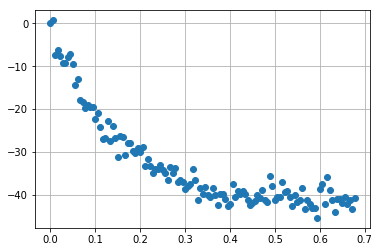

In [6]:
time_x, data_x = format_data(itmx, i_ind_x, e_ind_x, c_hori_x , c_vert_x)
pl.plot(time_x, data_x, 'o')
pl.grid()

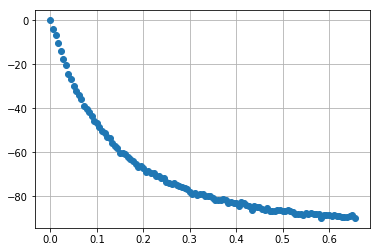

In [7]:
time_y, data_y = format_data(itmy, i_ind_y, e_ind_y, c_hori_y , c_vert_y)
pl.plot(time_y, data_y, 'o')
pl.grid()

In [8]:
# Define Log Likelihood
def lnprob(theta, t, signal, uncs) :
    amplitude = theta[0]
    tau = theta[1]
    
    if amplitude <= -40.0 or amplitude > 40.0 or a <= -1.0 or a > 1.0 :
        return -np.inf
    else :
        new_signal = TL(t,amplitude,tau)
        return -np.sum(np.abs(signal - new_signal)**2/(2*np.square(uncs)))

In [9]:
def run_mcmc(t_vect, data, amp_guess, tau_guess):
    ndim = 2
    nwalkers = 100
    rr = np.transpose(np.vstack([np.random.normal(-1.0, 1.0, nwalkers),
                                 np.random.normal(0, 5.0, nwalkers) ]))
    p0 = np.tile(np.array([amp_guess, tau_guess]), (nwalkers,1)) + rr
    rr[0]

    samp = mc.EnsembleSampler(nwalkers, ndim, lnprob, args=[t_vect, data, uncs])

    pos, prob, state = samp.run_mcmc(p0, 100)
    samp.reset()

    samp.run_mcmc(pos, 500);

    results = np.copy(samp.flatchain) 
    
    return results

def plot_results(t_vect, signal, results,filename):
    amp_mean, a_mean = np.mean(results,axis=0)
    amp_median, a_median = np.median(results,axis=0)
    covmat = np.cov(results.T)
    amp_unc, a_unc = np.sqrt(np.diag(covmat))
    print("Means            = ", amp_mean, a_mean)
    print("Medians          = ",amp_median, a_median)
    print("Uncertainties    = ",amp_unc, a_unc)
    print("Covariant Matrix = ", covmat)
    
    arm_abs = 1e9*a_median/p_arm
    
    print("ARM Absorption Estimate =  ",arm_abs, " [PPB]")

    recovered_exp = TL(t_vect,amp_median,a_median)
    
    pl.figure(figsize=(10, 5), dpi=300)
    pl.plot(t_vect, np.real(recovered_exp), '--', linewidth =3, label='Recovered exponential function')
    pl.plot(t_vect, signal, 'o', label='HWS Signal')
    pl.legend(loc='best', fontsize=14)
    pl.xlabel('Time [Hours]', fontsize=14)
    pl.ylabel('Spherical Power [microdiopters]', fontsize=14)
    pl.tick_params(axis='both', labelsize =12)
    pl.grid()
    pl.savefig("../../Figures/"+filename)

Quantiles:
[(0.16, -9.136761008584678), (0.5, -0.2693241413078491), (0.84, 8.521721470983564)]
Quantiles:
[(0.16, 0.03603920517435979), (0.5, 0.04837043637074815), (0.84, 0.06056258357234748)]
Means            =  -0.30112816265215936 0.04834068608187948
Medians          =  -0.2693241413078491 0.04837043637074815
Uncertainties    =  8.836049206991746 0.012355123374356406
Covariant Matrix =  [[7.80757656e+01 1.03852926e-01]
 [1.03852926e-01 1.52649074e-04]]
ARM Absorption Estimate =   331.7724760329516  [PPB]


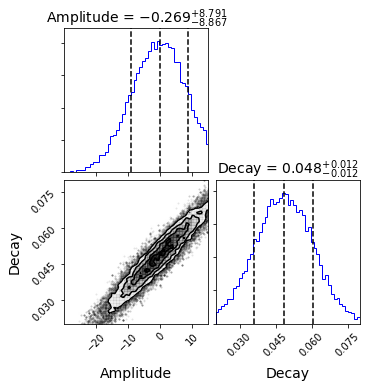

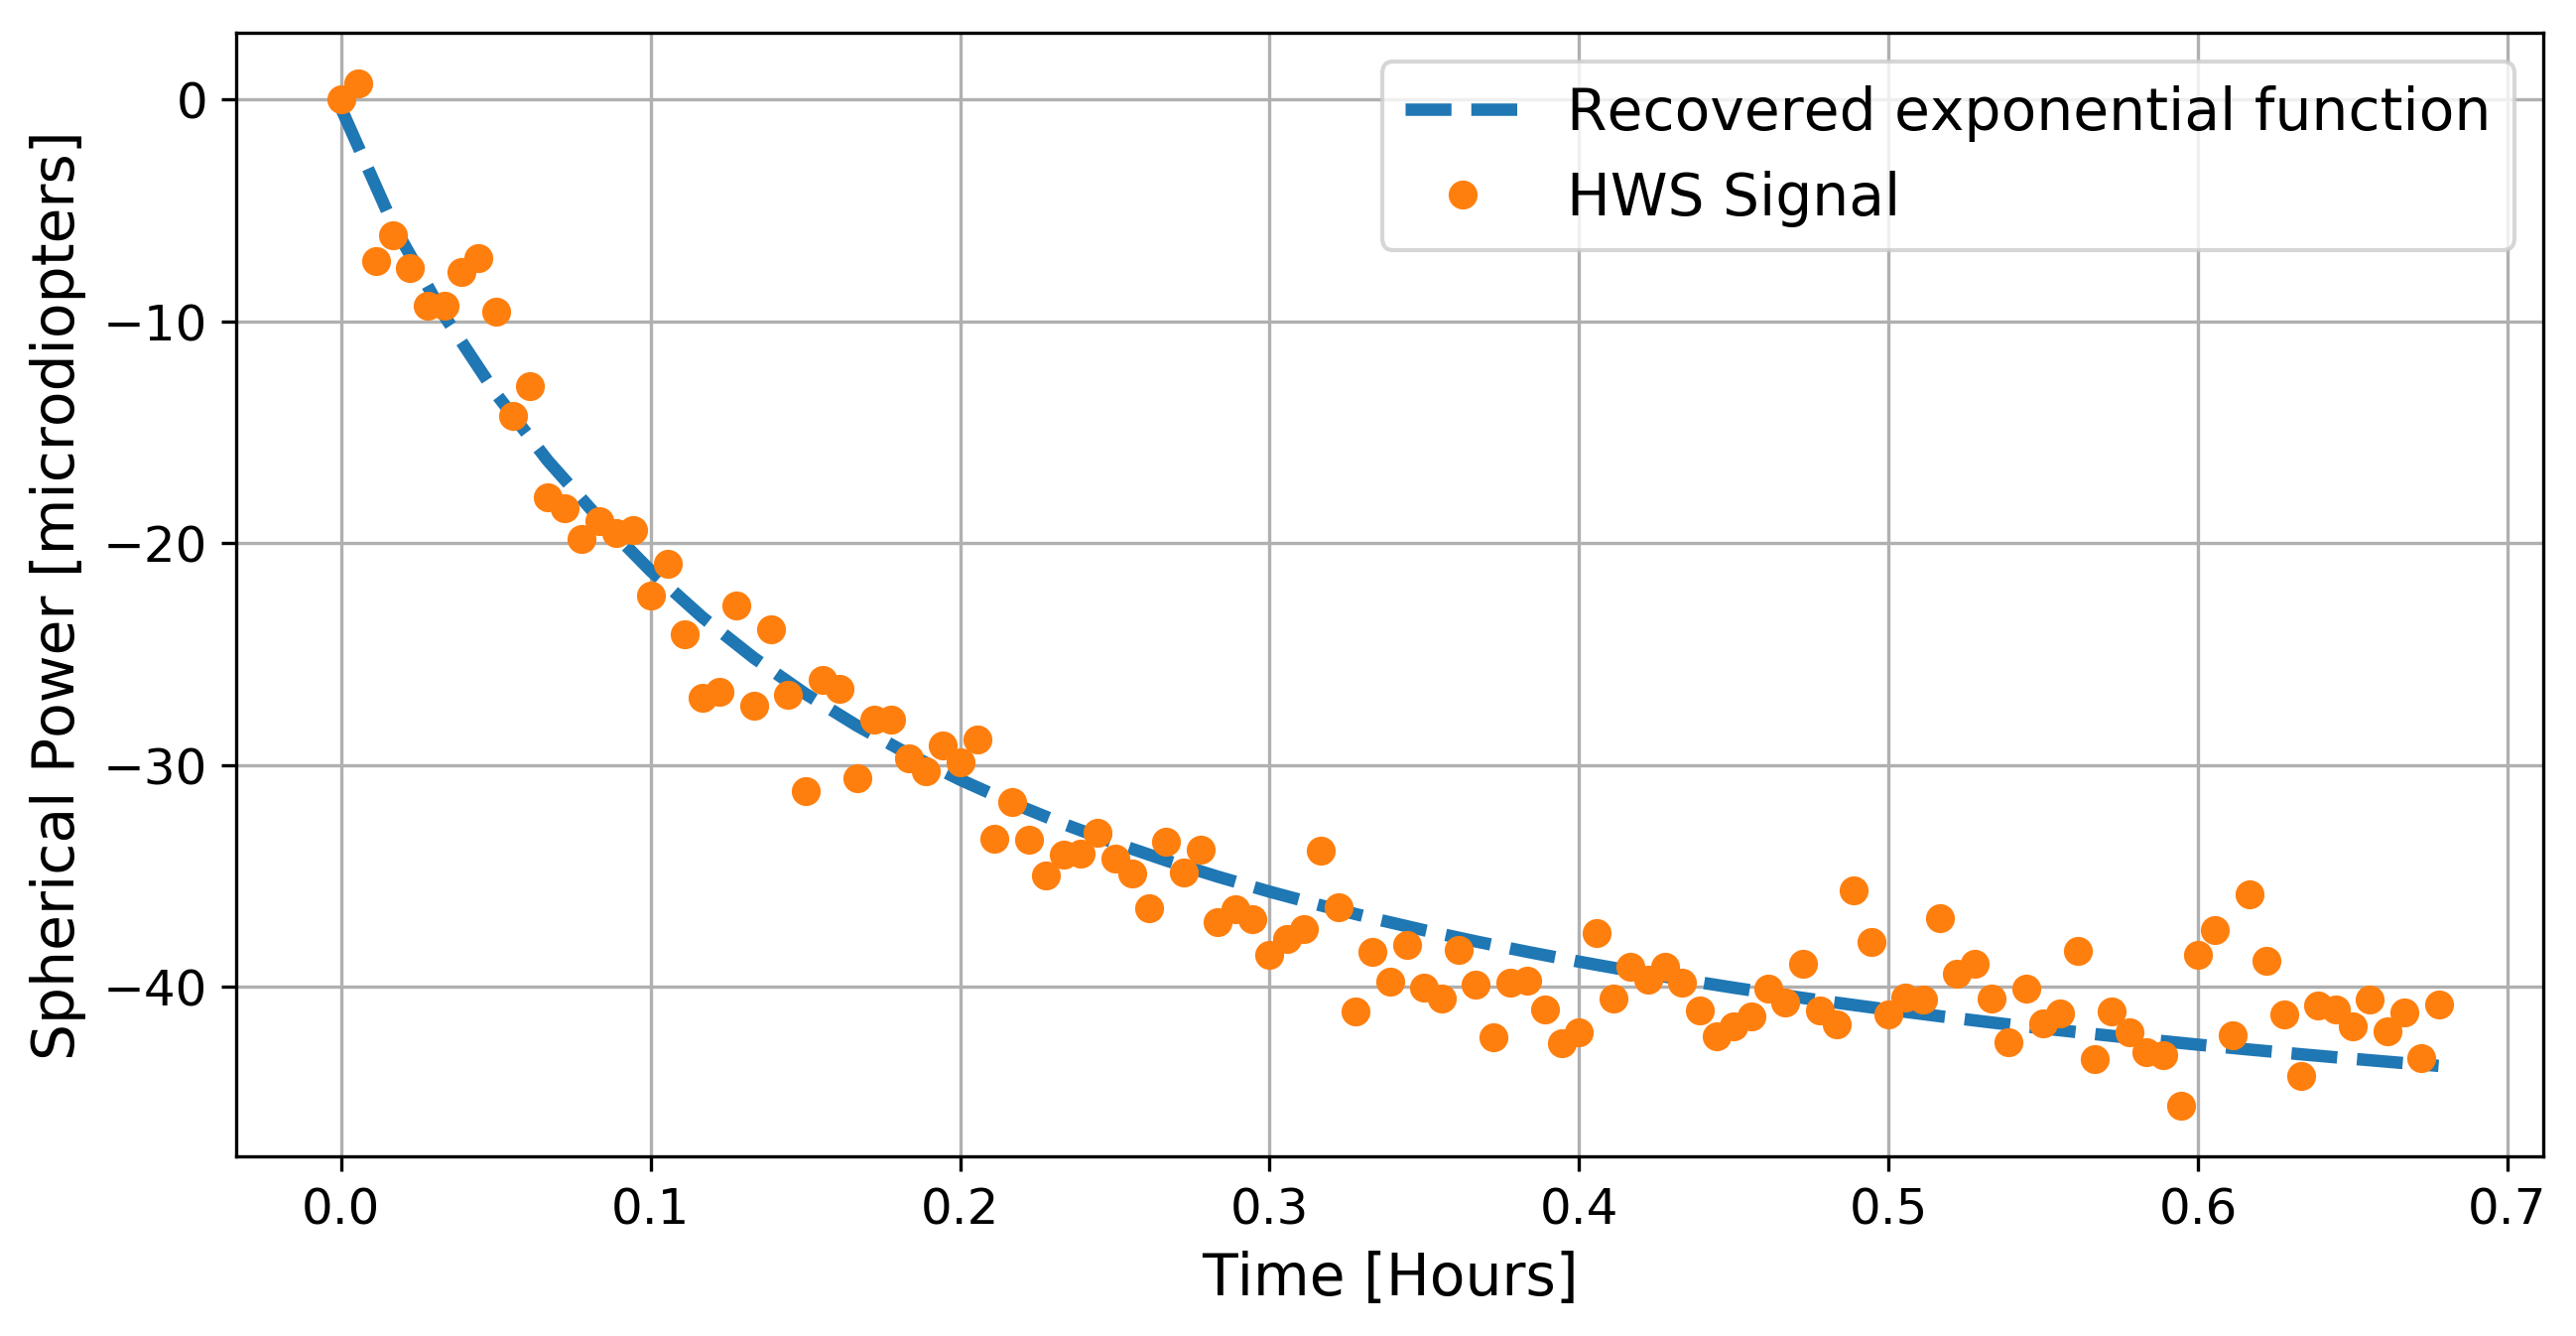

In [10]:
noise_std = 30.0
uncs = noise_std * np.ones(len(time_x))  # Uniform uncertainty in each point
results_x = run_mcmc(time_x,data_x, amp_guess_x, tau_guess_x)

range_list = [ [-30, 15], [0.02, 0.08] ]
h_c = corner.corner(results_x, 
                    bins=50, 
                    labels=['Amplitude', 'Decay'],
                    label_kwargs={'fontsize':14},
                    show_titles=True,
                    title_kwargs={'fontsize':14},
                    title_fmt='.3f' ,
                    quantiles=[0.16, 0.5, 0.84],
                    range=range_list,
                    verbose=True,
                    hist_kwargs={'color':'b'})
h_c.savefig("../../Figures/MCMC_ITMX_abs.png")

plot_results(time_x, data_x, results_x, 'MCMC_ITMX_ABS_FIT.png')

Quantiles:
[(0.16, -11.543796787851033), (0.5, -2.8160036055800273), (0.84, 5.960161798929202)]
Quantiles:
[(0.16, 0.08776229583623707), (0.5, 0.10016321006029424), (0.84, 0.11254269454568691)]
Means            =  -2.8080572311702485 0.10014751659224241
Medians          =  -2.8160036055800273 0.10016321006029424
Uncertainties    =  8.73210910310915 0.012324266849805705
Covariant Matrix =  [[7.62497294e+01 1.01914484e-01]
 [1.01914484e-01 1.51887553e-04]]
ARM Absorption Estimate =   687.018739181957  [PPB]


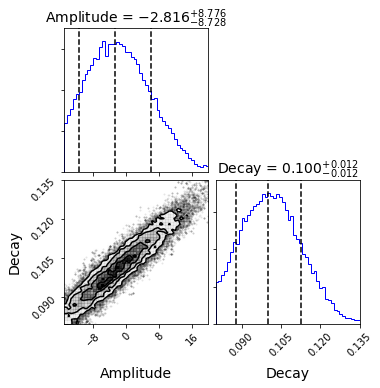

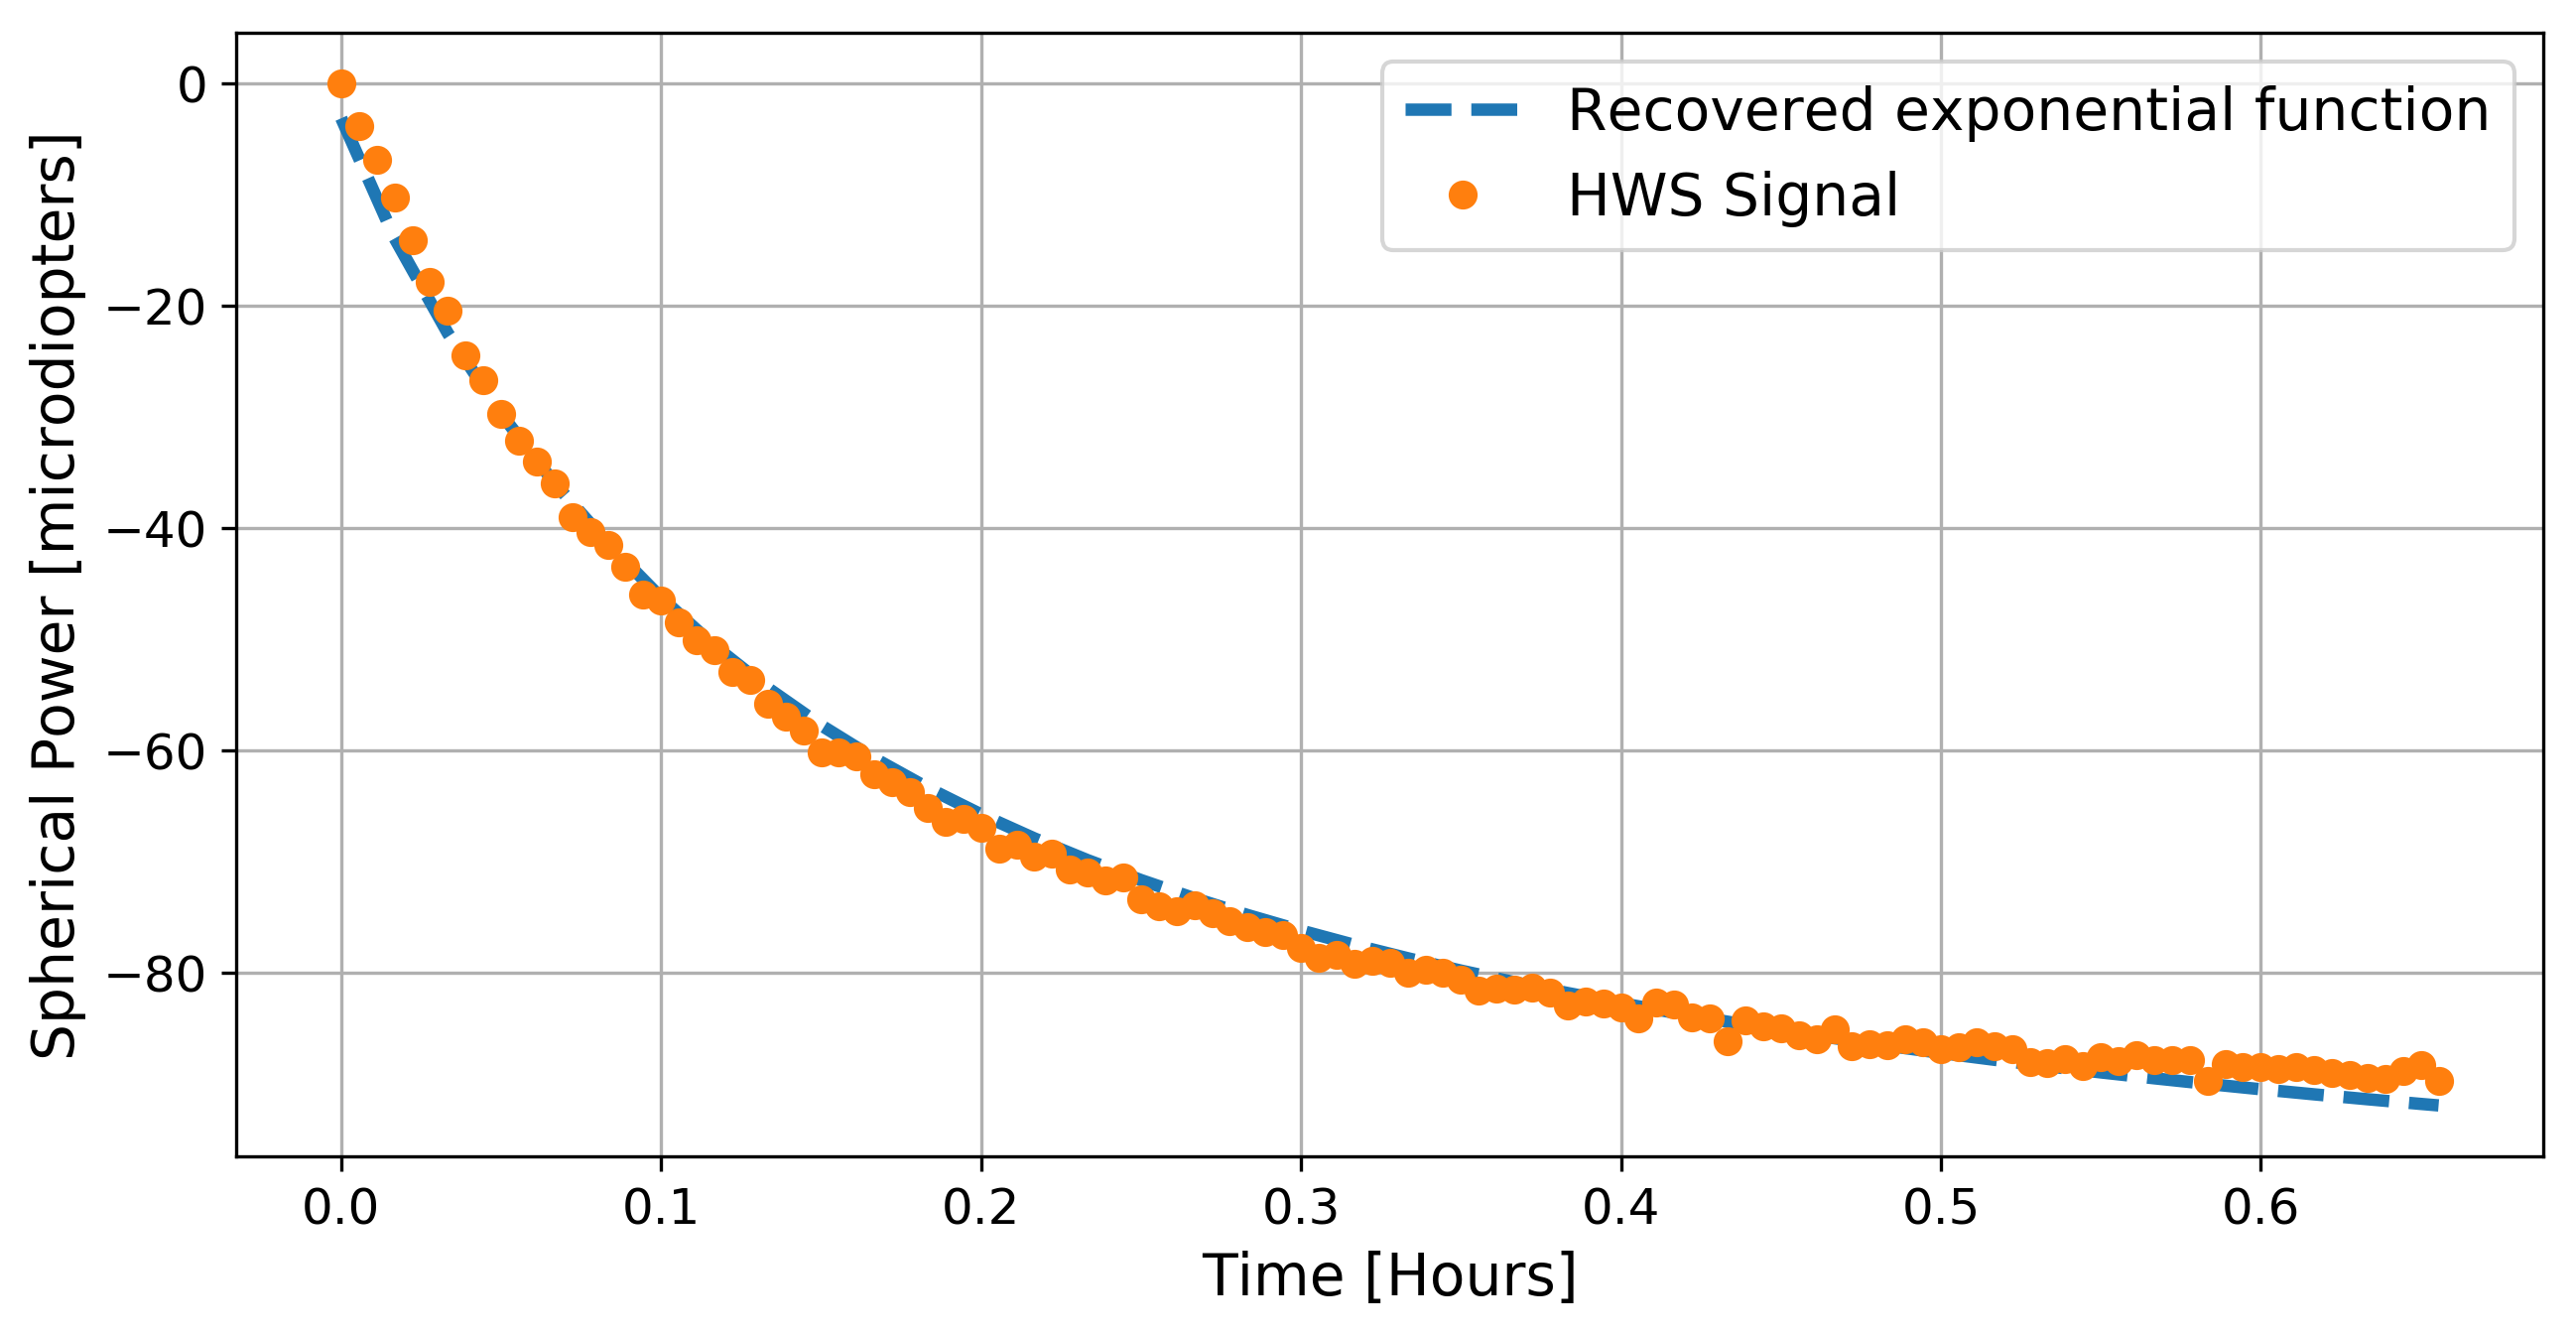

In [11]:
noise_std = 30.0
uncs = noise_std * np.ones(len(time_y))  # Uniform uncertainty in each point

results_y = run_mcmc(time_y,data_y, amp_guess_y, tau_guess_y)

range_list = [ [-15, 20], [0.08, 0.135] ]
h_c = corner.corner(results_y, 
                    bins=50, 
                    labels=['Amplitude', 'Decay'],
                    label_kwargs={'fontsize':14},
                    show_titles=True,
                    title_kwargs={'fontsize':14},
                    title_fmt='.3f' ,
                    quantiles=[0.16, 0.5, 0.84],
                    range=range_list,
                    verbose=True,
                    hist_kwargs={'color':'b'})
h_c.savefig("../../Figures/MCMC_ITMY_abs.png")

plot_results(time_y,data_y,results_y,'MCMC_ITMY_ABS_FIT.png')

In [12]:
# Weighted uncertainty to ignore the pt absorber
tau=0.05
offset = 5
uncs=(80.0-offset)*np.exp(-np.linspace(0,time_y[-1],len(time_y))/tau)+offset

results_y = run_mcmc(time_y,data_y, amp_guess_y, tau_guess_y)

Quantiles:
[(0.16, -14.581714970297792), (0.5, -10.2794221480323), (0.84, -6.0483706045540995)]
Quantiles:
[(0.16, 0.0851645142207021), (0.5, 0.09059981515283744), (0.84, 0.09593299900676046)]
Means            =  -10.315233261824735 0.09053536082107215
Medians          =  -10.2794221480323 0.09059981515283744
Uncertainties    =  4.334660193141982 0.005486233090877689
Covariant Matrix =  [[1.87892790e+01 2.35923431e-02]
 [2.35923431e-02 3.00987535e-05]]
ARM Absorption Estimate =   621.4234821243497  [PPB]


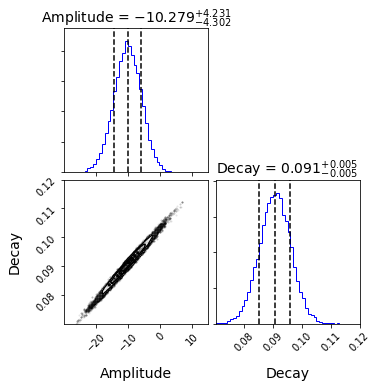

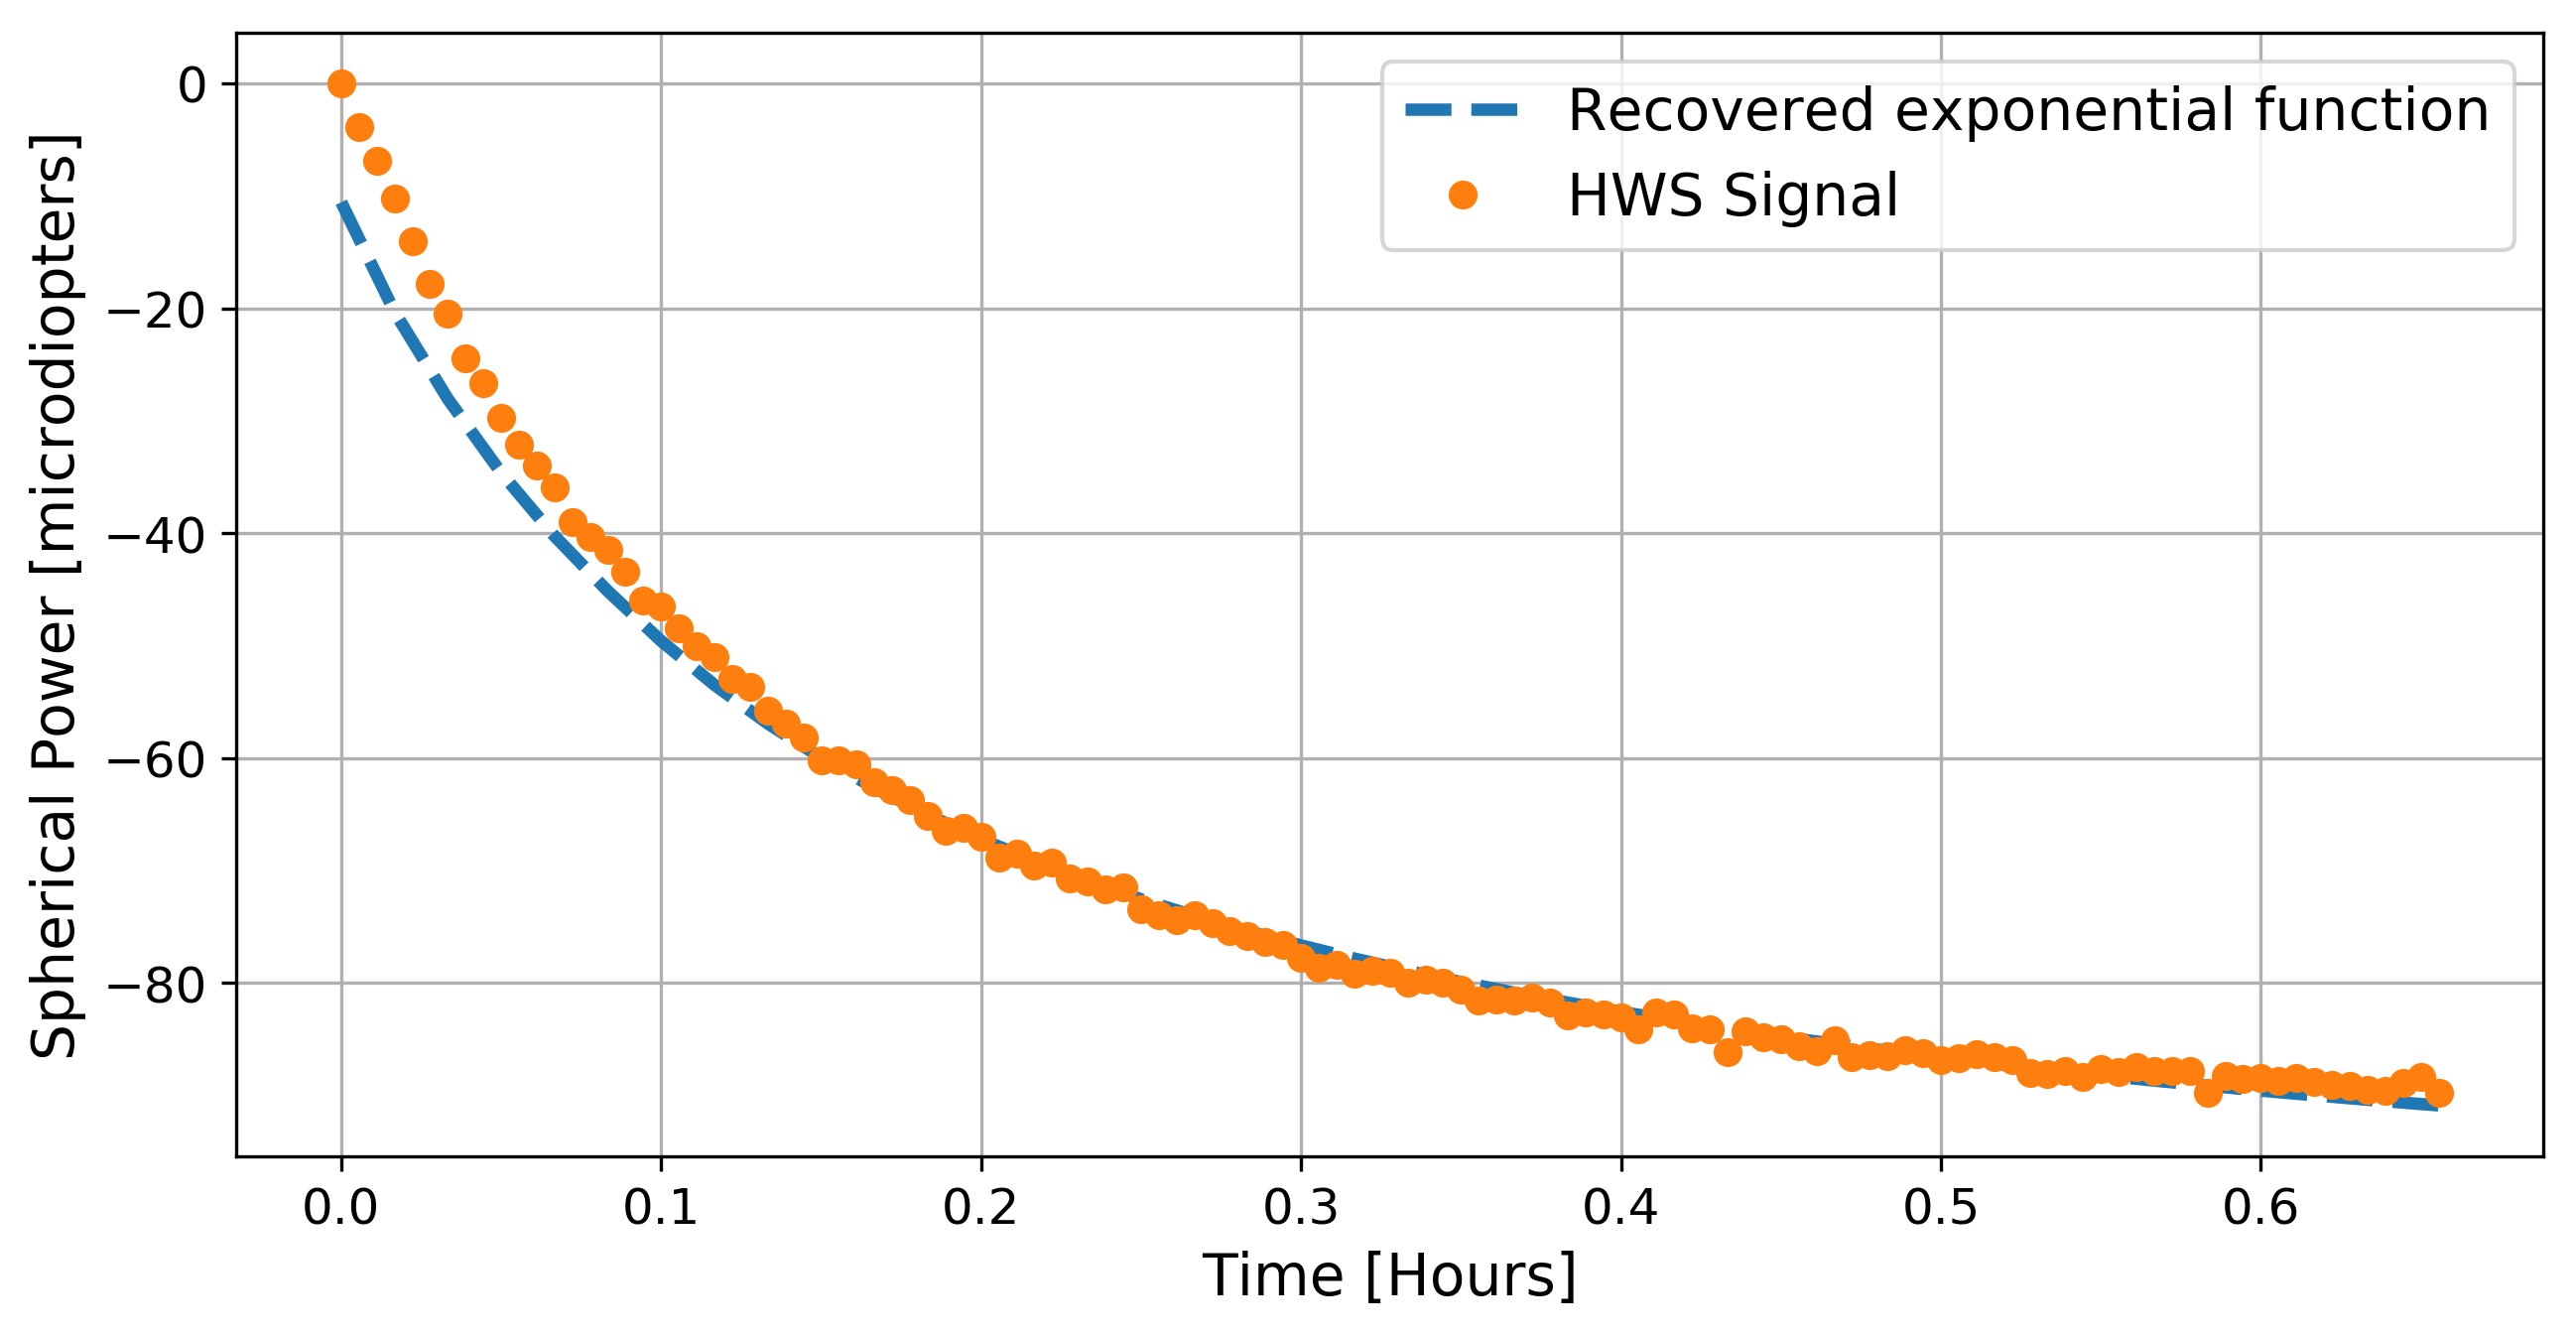

In [13]:
range_list = [ [-30, 15], [0.07, 0.12] ]
h_c = corner.corner(results_y, 
                    bins=50, 
                    labels=['Amplitude', 'Decay'],
                    label_kwargs={'fontsize':14},
                    show_titles=True,
                    title_kwargs={'fontsize':14},
                    title_fmt='.3f' ,
                    quantiles=[0.16, 0.5, 0.84],
                    range=range_list,
                    verbose=True,
                    hist_kwargs={'color':'b'})
h_c.savefig("../../Figures/MCMC_ITMY_abs_adj.png")

plot_results(time_y,data_y,results_y,'MCMC_ITMY_ABS_FIT_adj.png')

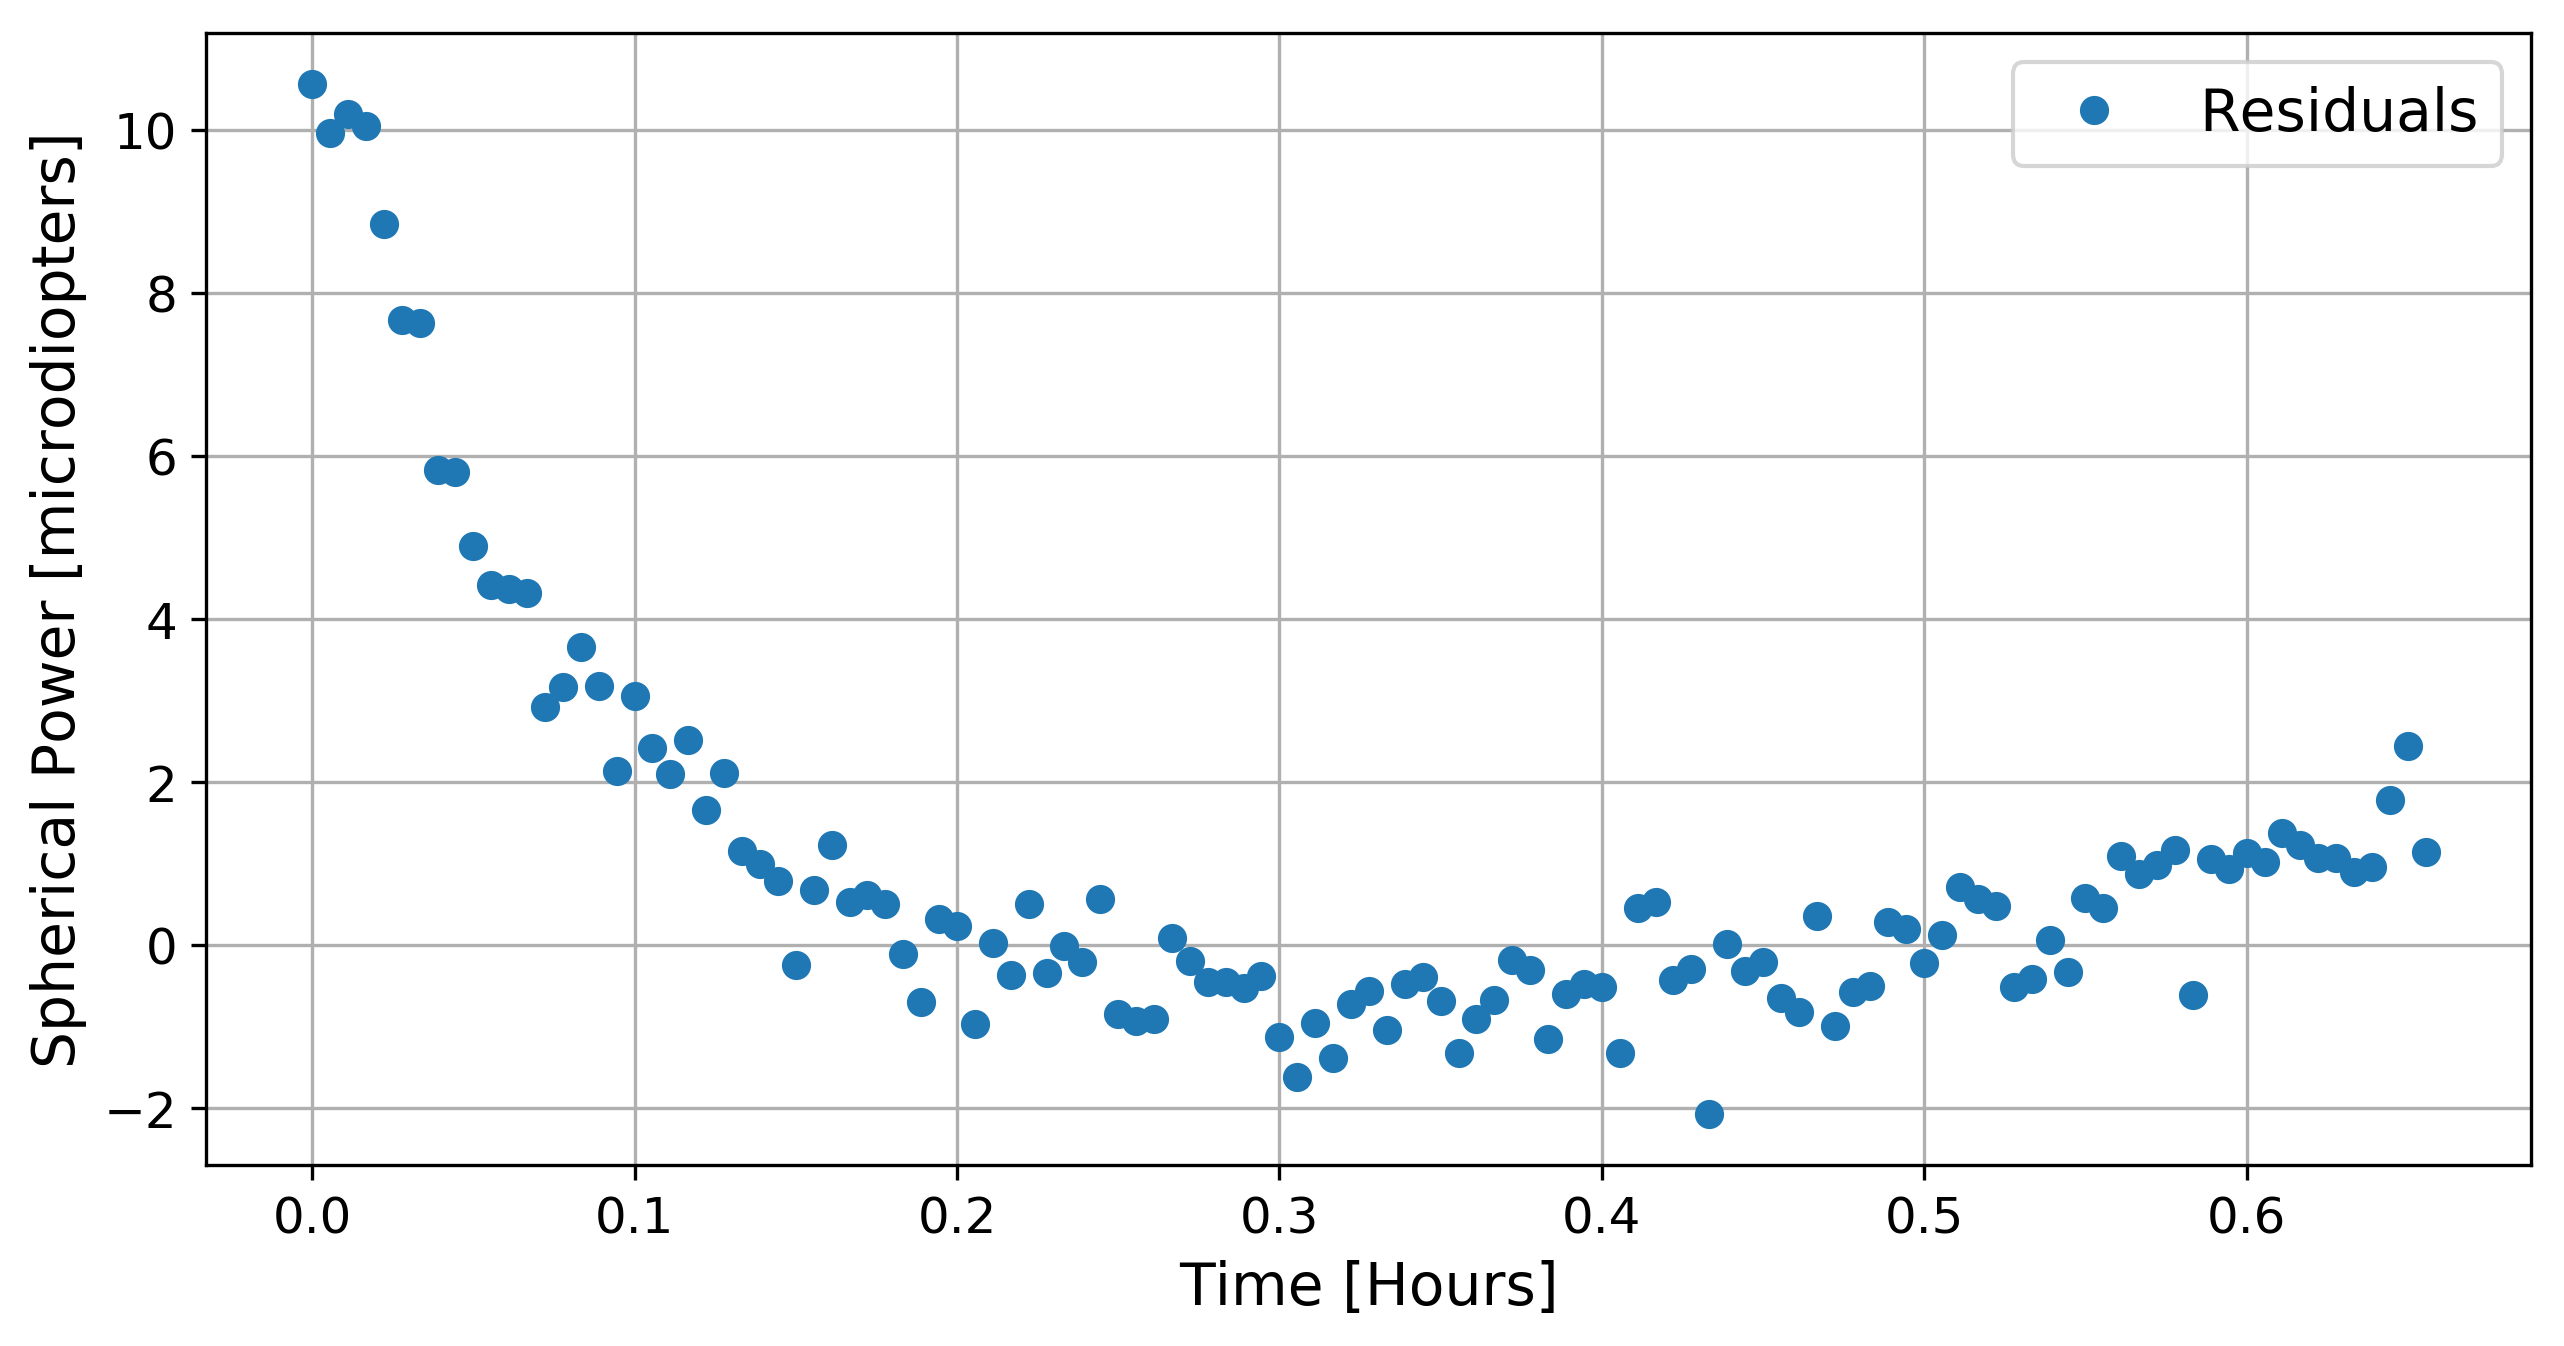

In [14]:
def plot_residuals(t_vect, signal, results):
    amp_median, a_median = np.median(results,axis=0)
    
    recovered_exp = TL(t_vect,amp_median,a_median)
    
    residual = signal - recovered_exp
    
    pl.figure(figsize=(10, 5), dpi=300)
    pl.plot(t_vect, np.real(residual), 'o', linewidth =3, label='Residuals')
    pl.legend(loc='best', fontsize=14)
    pl.xlabel('Time [Hours]', fontsize=14)
    pl.ylabel('Spherical Power [microdiopters]', fontsize=14)
    pl.tick_params(axis='both', labelsize =12)
    pl.grid()
    
plot_residuals(time_y, data_y,results_y)

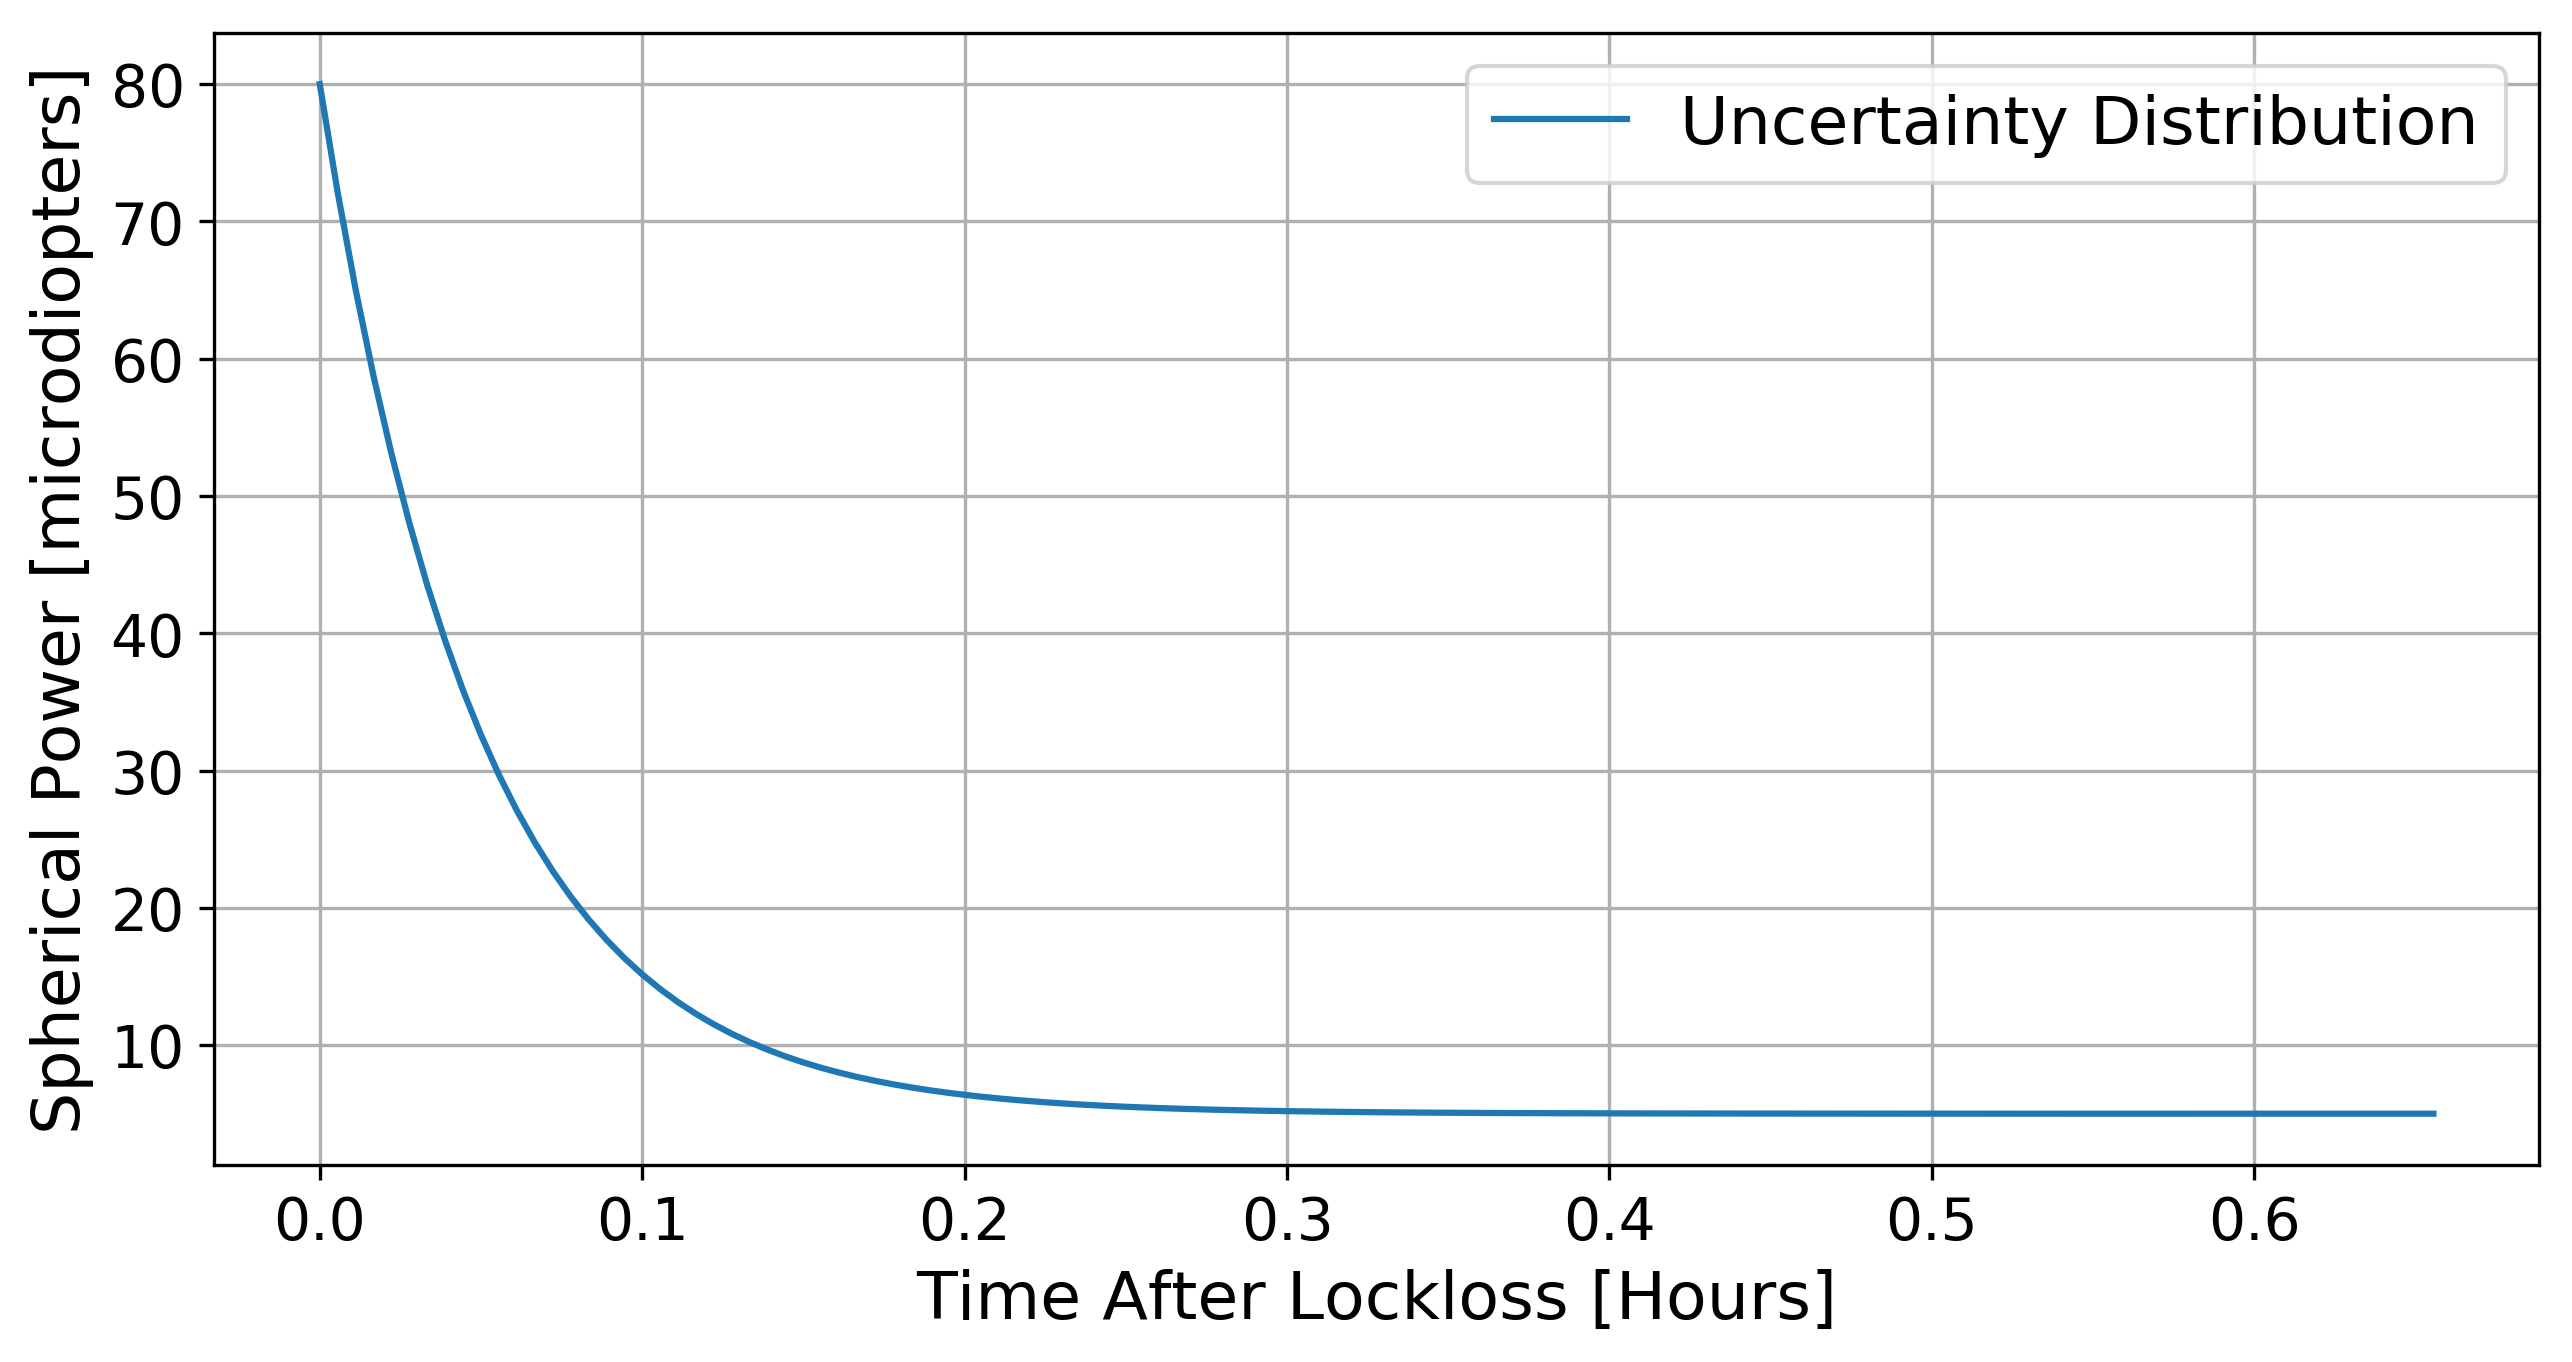

In [15]:
pl.figure(figsize=(10, 5), dpi=300)
pl.subplot(111)
pl.plot(time_y,uncs,label="Uncertainty Distribution")
pl.ylabel("Spherical Power [microdiopters]",fontsize = 16)
pl.xlabel("Time After Lockloss [Hours]",fontsize = 16)
pl.legend(fontsize=16)
pl.grid()
pl.tick_params(labelsize=14)